# Intrdouction

In [1]:
# Save the Notebook as your group number and section. For Example your group is 5 and your section is 01
# you final title should be " Final Project Group 5 Section 01"


# Uber vs Lyft Price Prediction
# Lynne Chenn
# Mihir Koyande
# Harsh Gandhi
# Sahil Sahil
# Dhruv Shah
# Group 2 & Class Section 3
# 4550 Analytics Programming

# Theyab Alhwiti
# Data


# Python libraries and packages. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import sklearn
%matplotlib inline
import re
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Data Description

In [3]:
# creating Data path and reading usign pandas csv function
data_path = '/Users/mihir25/Downloads/rideshare_kaggle 2.csv'
rideshare_data = pd.read_csv(data_path,low_memory=False)
# setting max coloums ON
pd.set_option('display.max_columns', None)
# displaying first 5 rows
rideshare_data.head()
# displaying All the columns
rideshare_data.columns
# statistics for hour column
rideshare_data.hour.describe()

count    693071.000000
mean         11.619137
std           6.948114
min           0.000000
25%           6.000000
50%          12.000000
75%          18.000000
max          23.000000
Name: hour, dtype: float64

# Data Cleaning and Preparation

<AxesSubplot:xlabel='price', ylabel='cab_type'>

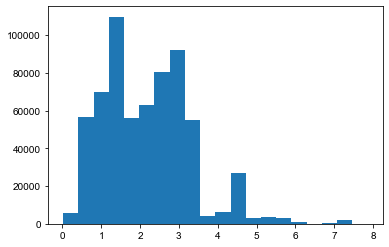

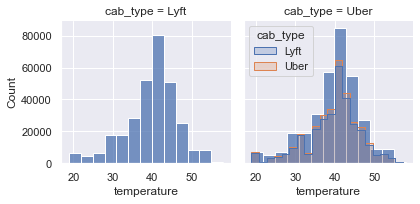

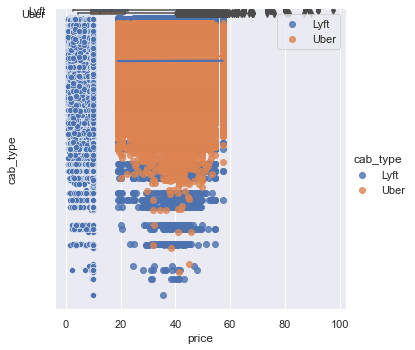

In [4]:
# Check to see if any of the rows is duplicated 
rideshare_data[rideshare_data.duplicated()] #No duplicate rows found
# Check to see which columns contain the missing values 
rideshare_data.columns[rideshare_data.isnull().any()]
# adding all missing values in price column
sum(np.isnan(rideshare_data['price']))
# extract the rows with the missing values; there are 55095 rows out of 693071 rows that contain the missing price values. 
rideshare_data[rideshare_data.isnull().any(axis = 1)]
# So missing values of price cant be imputed by mean, median, mode or logit function as it will be not appropriate
# So only option we have to drop the missing values in price
# Drop the rows that contain NA values 
rideshare_data = rideshare_data.dropna()
# so now after dropping missing values we are left with  637976 rows × 57 columns
# something about the data
# only Nov and Dec
# even distribution in time of the day
# not everyday
# queried, not real passenger data
# no surge_multiplier for uber
# plotting histogram for distance
plt.hist(rideshare_data.distance, bins = 20)
# Creating a crosstabulation for surge multiplier and cab type
# its a simple crosstabulation table of surge multipler and cab type which is uber and lyft
pd.crosstab(rideshare_data.surge_multiplier, rideshare_data.cab_type)
# Creating a plot on temerature and cab type
sns.set_theme(style="darkgrid")
sns.displot(
    rideshare_data, x="temperature", col="cab_type",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)
# combined plot of cabtypes 
sns.histplot(rideshare_data, x="temperature", hue="cab_type", element="step", bins = 20)
# Creating a scatterplot on facetgrid with temperature, price and cab type
sns.lmplot(
    data=rideshare_data,
    x="temperature", y="price", hue="cab_type",
    height=5
)

# Statistics for price column where cab type is uber
rideshare_data['price'][rideshare_data['cab_type'] == "Uber"].describe()
# Statistics for price column where cab type is lyft
rideshare_data['price'][rideshare_data['cab_type'] == "Lyft"].describe()
# Creating a boxplot for price and cab type
sns.boxplot(x='price', y='cab_type', data=rideshare_data, orient="h")
# Creating scatterplot for visibility and price
sns.scatterplot(x="visibility", y="price", data=rideshare_data)

#---------------------------------------------------------------------------------------------------------------------


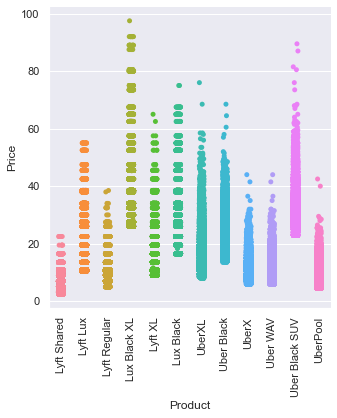

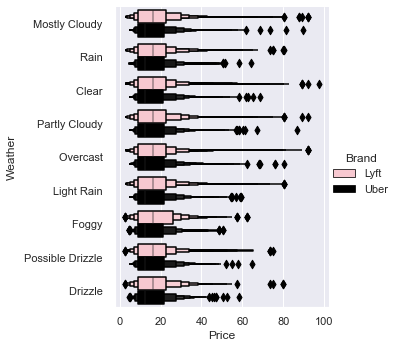

<function matplotlib.pyplot.show(close=None, block=None)>

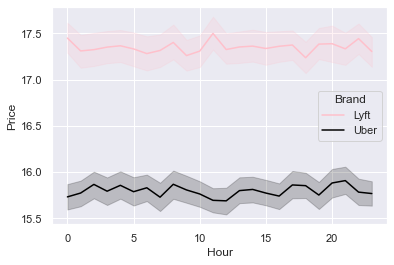

In [8]:
# EDA
# Creating a new dataframe df1 with selected columns we want
df1 = rideshare_data[['id', 'hour', 'day', 'month', 'datetime', 'source', 'destination', 'cab_type', 'name', 'price', 'surge_multiplier', 'visibility', 'apparentTemperature', 'distance', 'short_summary']].copy()
# Printing the new dataframe df1
df1
# Seeing datatypes in dataframe df1
df1.dtypes
# renaming columns of df1 for our better understanding
df1 = df1.rename(columns={"price": "Price", "name": "Product", "short_summary": "Weather", "hour": "Hour", "cab_type": 'Brand'})
# replacing values in product column 
# like if Taxi then replaced as UberTaxi, Shared then Lyft Shared etc. as it will give us good understanding
df1.loc[df1['Product'] == 'Taxi', 'Product'] = 'UberTaxi'
df1.loc[df1['Product'] == 'Shared', 'Product'] = 'Lyft Shared'
df1.loc[df1['Product'] == 'Lux', 'Product'] = 'Lyft Lux'
df1.loc[df1['Product'] == 'Lyft', 'Product'] = 'Lyft Regular'
df1.loc[df1['Product'] == 'Black SUV', 'Product'] = 'Uber Black SUV'
df1.loc[df1['Product'] == 'WAV', 'Product'] = 'Uber WAV'
df1.loc[df1['Product'] == 'Black', 'Product'] = 'Uber Black'
# Plotting catplot for product and price
# catplot shows frequencies of the categories of one, two or three categorical variables.
ax = sns.catplot(x='Product', y = 'Price', data=df1)
ax.set_xticklabels(rotation=90)
plt.show()

# plotting catplot with 3 variables price, weather and brand
custom_palette = ['pink', 'black']
sns.set_palette(custom_palette)
sns.catplot(x="Price", y="Weather", hue="Brand", kind="boxen", data=df1)
plt.show()

# plotting line plot for hour, price and brand
sns.set_palette(custom_palette)
sns.lineplot(df1['Hour'], df1['Price'], hue=df1['Brand'])
plt.show


# Modeling 

In [22]:
weekday = rideshare_data.datetime.apply(lambda x: datetime.fromisoformat(str(x)).weekday())
rideshare_data['Fri'] = (weekday==4).astype(int)
rideshare_data['Sat'] = (weekday==5).astype(int)
rideshare_data['Sun'] = (weekday==6).astype(int)

# change short summry of weather to binary variables
print(rideshare_data.short_summary.unique())
for i in rideshare_data.short_summary.unique():
    rideshare_data[i] = (rideshare_data.name == i).astype('int')
    
# split data for uber and lyft
lyft = rideshare_data[:][rideshare_data.cab_type == "Lyft"]
uber = rideshare_data[:][rideshare_data.cab_type == "Uber"]

print(lyft.product_id.unique())
print(lyft.name.unique())
print(uber.product_id.unique())
print(uber.name.unique())

pd.crosstab(lyft.product_id,lyft.name)

pd.crosstab(uber.product_id,uber.name)



[' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Cloudy ' ' Overcast '
 ' Light Rain ' ' Foggy ' ' Possible Drizzle ' ' Drizzle ']
['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux']
['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black']
['6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2']
['UberXL' 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']


name,Black,Black SUV,UberPool,UberX,UberXL,WAV
product_id,,,,,,
55c66225-fbe7-4fd5-9072-eab1ece5e23e,0,0,0,55094,0,0
6c84fd89-3f11-4782-9b50-97c468b19529,55095,0,0,0,0,0
6d318bcc-22a3-4af6-bddd-b409bfce1546,0,55096,0,0,0,0
6f72dfc5-27f1-42e8-84db-ccc7a75f6969,0,0,0,0,55096,0
997acbb5-e102-41e1-b155-9df7de0a73f2,0,0,55091,0,0,0
9a0e7b09-b92b-4c41-9779-2ad22b4d779d,0,0,0,0,0,55096


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


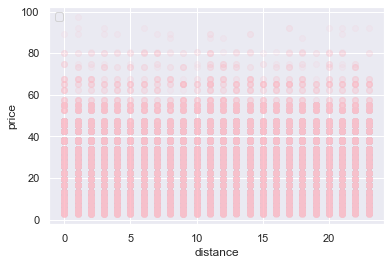

Linear Regression Lyft train R squared: 0.9365
Linear Regression Lyft test R squared: 0.9363
Linear Regression Lyft test RMSE: 2.5324
Linear Lyft Accuracy: 84.99 %.


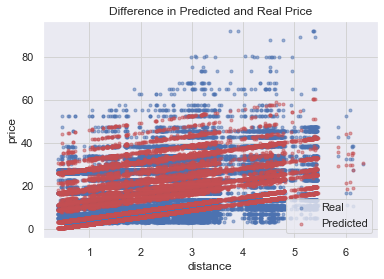

Linear Regression Uber train R squared: 0.9200
Linear Regression Uber test R squared: 0.9188
Linear Regression Uber test RMSE: 2.4425
Linear Uber Accuracy: 88.13 %.


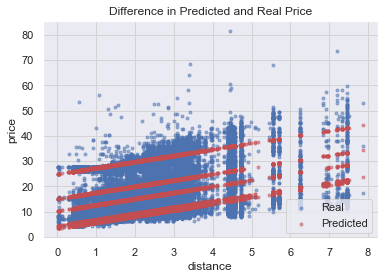

Random Forest Lyft train R squared is: 0.9806
Random Forest Lyft test R squared": 0.9759
Random Forest Lyft RMSE: 1.5575
Random Forest Lyft Accuracy: 91.46 %.


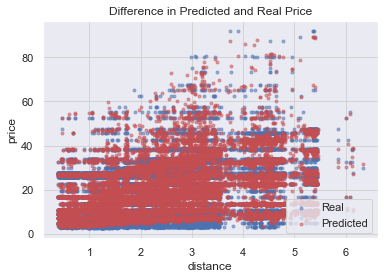

Random Forest Uber train R squared is: 0.9536
Random Forest Uber test R squared": 0.9480
Random Forest Uber RMSE: 1.9546
Random Forest Uber Accuracy: 91.79 %.


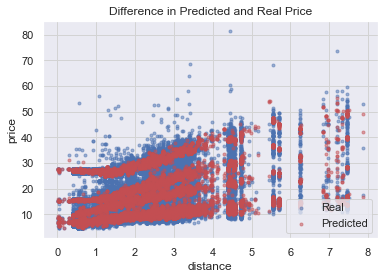

In [26]:
#Creat biary variables for uber and lyft cab type
for i in lyft.name.unique():
    lyft[i] = (lyft.name == i).astype('int')

for i in uber.name.unique():
    uber[i] = (uber.name == i).astype('int')

np.random.seed(19680801)

x = lyft['hour']
y = lyft['price']

plt.scatter(x, y,alpha = 0.1)
plt.xlabel("distance")
plt.ylabel("price")
plt.legend(loc='upper left')
plt.show()

lyft_X = lyft[['distance','surge_multiplier','Fri', 'Sat','Sun',
               'Shared', 'Lyft XL', 'Lux Black XL', 'Lux', 'Lux Black', #Use Lyft as the baseline
               ' Mostly Cloudy ', ' Rain ', ' Partly Cloudy ', #Use Clear as baseline
               ' Overcast ', ' Light Rain ', ' Foggy ', ' Possible Drizzle ',
               ' Drizzle ']]
lyft_y = lyft['price']

uber_X = uber[['distance','surge_multiplier','Fri', 'Sat','Sun',
               'UberPool','UberXL','Black','Black SUV', 'WAV', #Use UberX as base line
               ' Mostly Cloudy ', ' Rain ', ' Partly Cloudy ', #Use Clear as baseline
               ' Overcast ', ' Light Rain ', ' Foggy ', ' Possible Drizzle ',
               ' Drizzle ']]
uber_y = uber['price']

#train test split
lyft_X_train, lyft_X_test, lyft_y_train, lyft_y_test = train_test_split(
    lyft_X, lyft_y, test_size=0.20, random_state=325)
uber_X_train, uber_X_test, uber_y_train, uber_y_test = train_test_split(
    uber_X, uber_y, test_size=0.20, random_state=325)

#linear of lyft

lr = LinearRegression() 
lm_model = lr.fit(lyft_X_train, lyft_y_train)
lyft_y_pred = lm_model.predict(lyft_X_test)
l_lr_train_r2 = lr.score(lyft_X_train, lyft_y_train)
l_lr_test_r2 = lr.score(lyft_X_test, lyft_y_test)
print('Linear Regression Lyft train R squared: %.4f' % l_lr_train_r2)
print('Linear Regression Lyft test R squared: %.4f' % l_lr_test_r2)

lyft_lr_mse = mean_squared_error(lyft_y_pred, lyft_y_test)
lyft_lr_rmse = np.sqrt(lyft_lr_mse)
print('Linear Regression Lyft test RMSE: %.4f' % lyft_lr_rmse)

errors = abs(lyft_y_pred - lyft_y_test)
mape = 100 * (errors / lyft_y_test)
lyft_lr_accuracy = 100 - np.mean(mape)
print('Linear Lyft Accuracy:', round(lyft_lr_accuracy, 2), '%.')

# Define x axis
x_axis = lyft_X_test.distance 

# Build scatterplot
plt.scatter(x_axis, lyft_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, lyft_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

#linear of uber
lr = LinearRegression() 
lm_model = lr.fit(uber_X_train, uber_y_train)
uber_y_pred = lm_model.predict(uber_X_test)
u_lr_train_r2 = lr.score(uber_X_train, uber_y_train)
u_lr_test_r2 = lr.score(uber_X_test, uber_y_test)
print('Linear Regression Uber train R squared: %.4f' % u_lr_train_r2)
print('Linear Regression Uber test R squared: %.4f' % u_lr_test_r2)

uber_lr_mse = mean_squared_error(uber_y_pred, uber_y_test)
uber_lr_rmse = np.sqrt(uber_lr_mse)
print('Linear Regression Uber test RMSE: %.4f' % uber_lr_rmse)

errors = abs(uber_y_pred - uber_y_test)
mape = 100 * (errors / uber_y_test)
uber_lr_accuracy = 100 - np.mean(mape)
print('Linear Uber Accuracy:', round(uber_lr_accuracy, 2), '%.')

# Define x axis
x_axis = uber_X_test.distance 

# Build scatterplot
plt.scatter(x_axis, uber_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, uber_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

# Random Forest Model
# Random Forest for Lyft

regr = RandomForestRegressor(n_estimators = 500, random_state = 42)
regr.fit(lyft_X_train, lyft_y_train)
l_rf_train_r2 = regr.score(lyft_X_train,lyft_y_train)
l_rf_test_r2 = regr.score(lyft_X_test, lyft_y_test)
print('Random Forest Lyft train R squared is: %.4f' % l_rf_train_r2)
print('Random Forest Lyft test R squared": %.4f' % l_rf_test_r2)

predictions = regr.predict(lyft_X_test)
l_forest_mse = mean_squared_error(predictions, lyft_y_test)
l_forest_rmse = np.sqrt(l_forest_mse)
print('Random Forest Lyft RMSE: %.4f' % l_forest_rmse)

errors = abs(predictions - lyft_y_test)
mape = 100 * (errors / lyft_y_test)
lyft_rf_accuracy = 100 - np.mean(mape)
print('Random Forest Lyft Accuracy:', round(lyft_rf_accuracy, 2), '%.')

'''characteristics = lyft_X.columns
importances = list(regr.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];'''

# Define x axis
x_axis = lyft_X_test.distance 

# Build scatterplot
plt.scatter(x_axis, lyft_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

#---------------------------------------------------------------------------------------------------------------------
#random forest for Uber
regr = RandomForestRegressor(n_estimators = 500, random_state = 42)
regr.fit(uber_X_train, uber_y_train)
u_rf_train_r2 = regr.score(uber_X_train,uber_y_train)
u_rf_test_r2 = regr.score(uber_X_test, uber_y_test)
print('Random Forest Uber train R squared is: %.4f' % u_rf_train_r2)
print('Random Forest Uber test R squared": %.4f' % u_rf_test_r2)

predictions = regr.predict(uber_X_test)
u_forest_mse = mean_squared_error(predictions, uber_y_test)
u_forest_rmse = np.sqrt(u_forest_mse)
print('Random Forest Uber RMSE: %.4f' % u_forest_rmse)

predictions = regr.predict(uber_X_test)
errors = abs(predictions - uber_y_test)
mape = 100 * (errors / uber_y_test)
uber_rf_accuracy = 100 - np.mean(mape)
print('Random Forest Uber Accuracy:', round(uber_rf_accuracy, 2), '%.')

'''characteristics = uber_X.columns
importances = list(regr.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];'''

# Define x axis
x_axis = uber_X_test.distance 

# Build scatterplot
plt.scatter(x_axis, uber_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, predictions, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

# Performance Evaluation

In [27]:
lyft_data = {"Model": ["Linear Regression", "Random Forest"], 
"Train R2": [l_lr_train_r2, l_rf_train_r2],
"Test R2": [l_lr_test_r2, l_rf_test_r2],
"Test RMSE": [lyft_lr_rmse, l_forest_rmse],
"Accuracy": [lyft_lr_accuracy, lyft_rf_accuracy]}

uber_data = {"Model": ["Linear Regression", "Random Forest"], 
"Train R2": [u_lr_train_r2, u_rf_train_r2],
"Test R2": [u_lr_test_r2, u_rf_test_r2],
"Test RMSE": [uber_lr_rmse, u_forest_rmse],
"Accuracy": [uber_lr_accuracy, uber_rf_accuracy]}

lyft_summary_table = pd.DataFrame(lyft_data)
display(lyft_summary_table)
uber_summary_table = pd.DataFrame(uber_data)
display(uber_summary_table)

# Based on different metrics, 
# we can conclude that the Random Forest model is the best model and thus we could consider this as our final model.

,Model,Train R2,Test R2,Test RMSE,Accuracy
0,Linear Regression,0.936489,0.936337,2.532400,84.991037
1,Random Forest,0.980563,0.975919,1.557507,91.459743


,Model,Train R2,Test R2,Test RMSE,Accuracy
0,Linear Regression,0.920045,0.918768,2.442493,88.128347
1,Random Forest,0.953556,0.947979,1.954609,91.794412


# Steps for improving the performance

In [ ]:
# There are many ways to tackle this problem from different perspectives.
# We can refine the models to improve prediction accuracy.
# For example, we can consider the interactions between the variables, such as distance and cab types predictors.
# We can also explore different prediction error rates of Random Forests with the optimal values of the parameters.
# We plan to consider outside of data to incorporate traffic conditions and times.



# Analysis of figures and results

In [5]:
# Uber is more economical; however, Lyft also provides fair competition.

# People prefer to have shared rides during the nighttime.

# People avoid taking rides when it rains.

# When traveling long distances, the price does not increase linearly. 
# However, based on the time and demand, a surge can affect the cost.

# Uber can be the first choice for long distances.


# Business suggestion (based on your analysis what is your business recommendation?)

In [ ]:
# Price variation should be much higher in top line products as its a premium service but still it can be reduced
# pricing for shared cab should not affect by product type and hour as it is shared so customer are already paying average value and upto 2-3 cutomers join so it is still more profitable for company